## Image classification by convolutional neural networks of Chinese MNIST datasets using the TensorFlow Python library

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import imageio
import skimage
import skimage.io
import skimage.transform
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf

2022-06-28 22:02:38.675839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 22:02:38.675924: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Initialization of parameters

In [2]:
IMAGE_PATH = 'chinese_mnist/data/data/'
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_CHANNELS = 1
RANDOM_STATE = 2022
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
CONV_2D_DIM_3 = 32
CONV_2D_DIM_4 = 64
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 64
NO_EPOCHS = 30
DROPOUT_RATIO = 0.4
PATIENCE = 5
VERBOSE = 1

Loading initial data

In [3]:
data_df = pd.read_csv("chinese_mnist/chinese_mnist.csv")
characters = ["一", "七", "万", "三", "九", "二", "五", "亿", "八", "六", "十", "千", "四", "百", "零", ]
data_df.sample(100).head()

,suite_id,sample_id,code,value,character
14582,61,2,9,8,八
1613,64,3,11,10,十
7165,23,5,2,1,一
9038,11,8,4,3,三
4985,98,5,14,10000,万


Preparation of data for training and splitting of data into training and testing sets

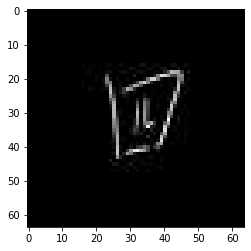

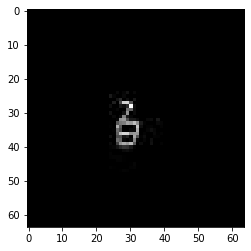

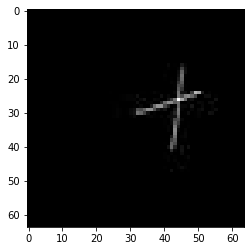

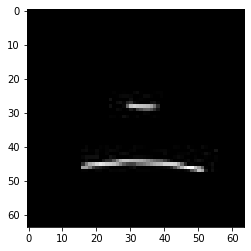

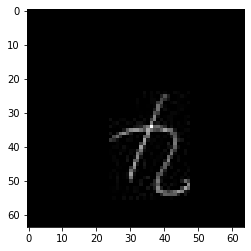

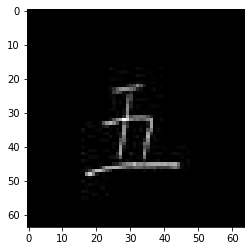

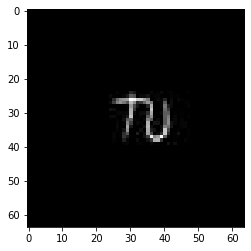

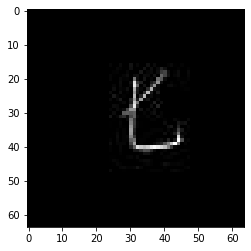

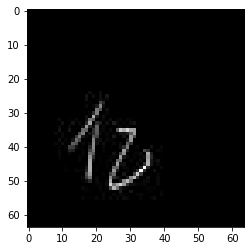

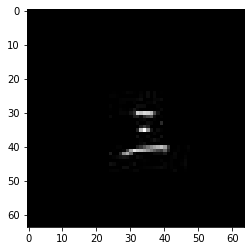

In [4]:
def create_file_name(x):
    file_name = f"input_{x[0]}_{x[1]}_{x[2]}.jpg"
    return file_name

data_df["file"] = data_df.apply(create_file_name, axis=1)

def read_image_sizes(file_name):
    image = skimage.io.imread("chinese_mnist/data/data/" + file_name)
    return list(image.shape)

m = np.stack(data_df['file'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h'])
data_df = pd.concat([data_df,df],axis=1, sort=False)

train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data_df["code"].values)
train_df, val_df = train_test_split(train_df, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=train_df["code"].values)

def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT, 1), mode='reflect')
    return image[:,:,:]

def categories_encoder(dataset, var='character'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)

sample = sorted(random.sample(range(len(X_train)), 10))
for i in range(10):
    plt.imshow(X_train[sample[i]], cmap=plt.cm.gray)
    plt.show()

Building a convolutional model

In [5]:
model = Sequential()
model.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(MaxPool2D(MAX_POOL_DIM))
model.add(Dropout(DROPOUT_RATIO))
model.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(Dropout(DROPOUT_RATIO))
model.add(Flatten())
model.add(Dense(y_train.columns.size, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2022-06-28 22:03:43.095150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-28 22:03:43.095296: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-28 22:03:43.095356: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nightcity2): /proc/driver/nvidia/version does not exist
2022-06-28 22:03:43.096173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Learning a convolutional model

In [6]:
train_model  = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/30
150/150 [==============================] - 76s 502ms/step - loss: 1.6330 - accuracy: 0.4883 - val_loss: 0.8127 - val_accuracy: 0.7454
Epoch 2/30
150/150 [==============================] - 74s 494ms/step - loss: 0.7221 - accuracy: 0.7676 - val_loss: 0.5416 - val_accuracy: 0.8304
Epoch 3/30
150/150 [==============================] - 78s 517ms/step - loss: 0.4978 - accuracy: 0.8420 - val_loss: 0.3984 - val_accuracy: 0.8833
Epoch 4/30
150/150 [==============================] - 78s 517ms/step - loss: 0.3800 - accuracy: 0.8765 - val_loss: 0.3056 - val_accuracy: 0.9142
Epoch 5/30
150/150 [==============================] - 78s 519ms/step - loss: 0.3005 - accuracy: 0.9019 - val_loss: 0.2587 - val_accuracy: 0.9283
Epoch 6/30
150/150 [==============================] - 77s 514ms/step - loss: 0.2374 - accuracy: 0.9192 - val_loss: 0.2684 - val_accuracy: 0.9171
Epoch 7/30
150/150 [==============================] - 77s 515ms/step - loss: 0.1993 - accuracy: 0.9368 - val_loss: 0.2258 - val_ac

Plotting accuracy changes and loss function changes

In [7]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy', 'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(train_model)

Evaluation of the loss function and accuracy on the test set

In [8]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11690045893192291
Test accuracy: 0.9736666679382324


Accuracy testing and metrics for each class

In [9]:
def test_accuracy_report(model):
    predicted = model.predict(X_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y_test.columns)) 
    test_res = model.evaluate(X_test, y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])
    
test_accuracy_report(model)

94/94 [==============================] - 4s 43ms/step
              precision    recall  f1-score   support

           一       0.97      0.99      0.98       200
           七       0.99      0.96      0.98       200
           万       0.97      0.99      0.98       200
           三       0.96      0.95      0.96       200
           九       0.95      0.94      0.95       200
           二       0.96      0.94      0.95       200
           五       0.99      0.99      0.99       200
           亿       0.96      0.97      0.97       200
           八       0.97      0.98      0.98       200
           六       0.99      0.98      0.99       200
           十       0.97      0.96      0.97       200
           千       0.97      0.97      0.97       200
           四       0.98      0.99      0.99       200
           百       0.98      0.96      0.97       200
           零       0.99      0.99      0.99       200

    accuracy                           0.97      3000
   macro avg       0.97   